In [1]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import models
from keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
from keras.models import Model
#setting Gpu memory
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)




In [2]:
!tar -xf lfw.tgz


In [3]:
#setup paths
POSitive_PATH = os.path.join('data_2', 'positive')
NEGative_PATH = os.path.join('data_2', 'negative')
ANChor_PATH = os.path.join('data_2', 'anchor')

#os.makedirs(POSitive_PATH)
#os.makedirs(NEGative_PATH)
#os.makedirs(ANChor_PATH)


In [4]:
os.getcwd()
import os

folder_path = "Downloads\\cv_project\\data_2\\anchor"

if not os.path.isdir(folder_path):
    print(f"Error: Folder '{folder_path}' not found.")



Error: Folder 'Downloads\cv_project\data_2\anchor' not found.


In [5]:
os.listdir()

['.ipynb_checkpoints',
 'camera.py',
 'data',
 'data_2',
 'face_project.py.py',
 'face_recongnition.ipynb',
 'lfw',
 'lfw.tgz',
 'siamesemodelv2.h5',
 'training_checkpoints',
 'untitled',
 'Untitled.ipynb',
 'untitled1',
 'Untitled1.ipynb',
 'Untitled2.ipynb',
 'Untitled3.ipynb']

In [6]:
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEGative_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [7]:
!pip  install deepface

In [8]:
from deepface import DeepFace

In [9]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data

In [10]:
anchor = tf.data.Dataset.list_files(ANChor_PATH+'\*.jpg').take(30)
positive = tf.data.Dataset.list_files(POSitive_PATH+'\*.jpg').take(30)
negative = tf.data.Dataset.list_files(NEGative_PATH+'\*.jpg').take(300)

In [11]:
import uuid

In [12]:
dir_test = anchor.as_numpy_iterator()

In [13]:
print(dir_test.next())

b'data_2\\anchor\\IMG20220725125437.jpg'


In [14]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

In [15]:
img=preprocess(r'data_2\anchor\IMG20220726174224.jpg')

In [16]:
img.numpy().min()

0.038431562

In [17]:
img.numpy().max()

1.0

In [18]:
dataset.map(preprocess)

NameError: name 'dataset' is not defined

In [53]:
#anchor &positive=1
#negative=0

positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [54]:
samples = data.as_numpy_iterator()

In [55]:
examp=samples.next()

In [56]:
examp

(b'data_2\\anchor\\IMG20220729054940.jpg',
 b'data_2\\positive\\IMG20220730175007.jpg',
 1.0)

In [57]:
def preprocess_avi(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [58]:
result= preprocess_avi(*examp)

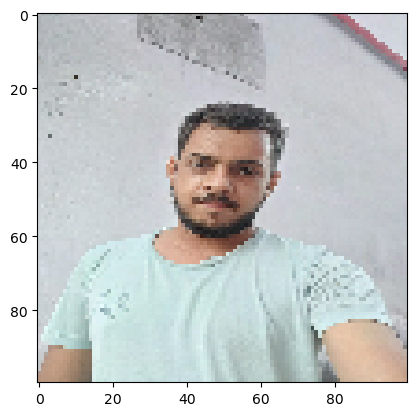

In [59]:
plt.imshow(result[1])

In [60]:
data=data.map(preprocess_avi)
data=data.cache()
data=data.shuffle(buffer_size=10000)

In [61]:
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [62]:
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(4)
test_data = test_data.prefetch(8)

In [63]:
inp = Input(shape=(100,100,3), name='input_image')

In [64]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [65]:
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_8 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 46, 46, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 17, 17, 128)       26

In [66]:
DeepFace.build_model("Facenet")

In [67]:
from deepface import DeepFace
result = DeepFace.detectFace("data_2\\anchor\\IMG20220729054938.jpg")

⚠️ Function detectFace is deprecated! Use extract_faces instead of this.


In [68]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [69]:
embedding = make_embedding()
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_12 (Conv2D)          (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 46, 46, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 20, 20, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 17, 17, 128)       26

In [70]:
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [71]:
l1 = L1Dist()
l1(anchor_embedding, validation_embedding)

NameError: name 'anchor_embedding' is not defined

In [72]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)
siamese_layer = L1Dist()
distances = siamese_layer(inp_embedding, val_embedding)
classifier = Dense(1, activation='sigmoid')(distances)
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_4')>

In [73]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

In [74]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')


In [83]:
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

In [76]:
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [77]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [78]:
test_batch = train_data.as_numpy_iterator()
batch_1 = test_batch.next()
X = batch_1[:2]
y = batch_1[2]
y

array([0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0.],
      dtype=float32)

In [79]:
tf.losses.BinaryCrossentropy??

In [80]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

In [81]:
from tensorflow.keras.metrics import Precision, Recall

In [82]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [84]:
EPOCHS = 10
train(train_data, EPOCHS)


 Epoch 1/10
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
3/3 [==============================] - 97s 29s/step
0.6910497 0.6 0.9230769

 Epoch 2/10
3/3 [==============================] - 92s 29s/step
0.6945151 0.21052632 0.8

 Epoch 3/10
3/3 [==============================] - 93s 29s/step
0.63407564 0.45454547 1.0

 Epoch 4/10
3/3 [==============================] - 92s 29s/step
0.5221044 0.3043478 1.0

 Epoch 5/10
3/3 [==============================] - 93s 29s/step
0.46356878 0.75 1.0

 Epoch 6/10
3/3 [==============================] - 93s 29s/step
0.3986964 0.6666667 1.0

 Epoch 7/10
3/3 [==============================] - 92s 29s/step
0.54409516 0.75 1.0

 Epoch 8/10
3/3 [==============================] - 92s 29s/step
0.2672842 0.95238096 1.0

 Epoch 9/10
3/3 [==============================] - 92s 28s/step
0.32339072 0.95652175 0.95652175

 Epoch 10/10
3/3 [=====================

In [87]:
from tensorflow.keras.metrics import Precision, Recall

In [86]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()
y_hat = siamese_model.predict([test_input, test_val])

1/1 [==============================] - 1s 626ms/step


In [88]:
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 1, 1, 0]

In [89]:
y_true

array([0., 1., 1., 0.], dtype=float32)

In [90]:
m=Recall()
m.update_state(y_true,y_hat)
m.result().numpy()

1.0

In [91]:
m=Precision()
m.update_state(y_true,y_hat)
m.result().numpy()

1.0

In [92]:
r=Recall()
p=Precision()
for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 [==============================] - 0s 408ms/step
0.7777778 0.875


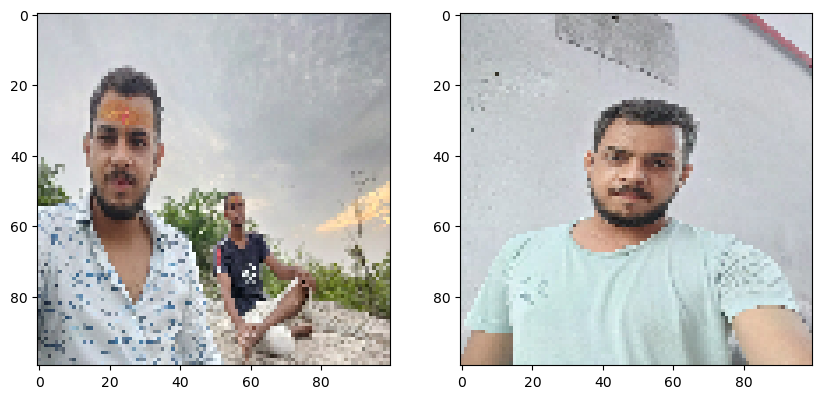

In [93]:
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.imshow(test_input[0])
plt.subplot(1,2,2)
plt.imshow(test_val[0])
plt.show()

In [94]:
siamese_model.save('siamesemodelv2.h5')
L1Dist

__main__.L1Dist

In [95]:
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})


In [96]:
siamese_model.predict([test_input, test_val])

1/1 [==============================] - 1s 658ms/step


array([[0.77728206],
       [0.6273616 ]], dtype=float32)

In [97]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

In [98]:
siamese_model.save('siamesemodelv2.h5')

In [99]:
L1Dist

__main__.L1Dist

In [100]:
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [101]:
siamese_model.predict([test_input, test_val])

1/1 [==============================] - 1s 640ms/step


array([[0.77728206],
       [0.6273616 ]], dtype=float32)

In [102]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

In [103]:
from deepface import DeepFace

In [104]:
Verify_PATH = os.path.join('data_2', 'Verify_face')

os.makedirs(Verify_PATH)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data_2\\Verify_face'

In [109]:
images_1= os.getcwd() + "\data_2\positive\IMG20220730152338.jpg"
images_2=os.getcwd()+"\data_2\Verify_face\Charles_Bronson_0003.jpg"
result = DeepFace.verify(img1_path = images_1, img2_path = images_2)

In [110]:
print(result)

{'verified': False, 'distance': 0.4431167697751457, 'threshold': 0.4, 'model': 'VGG-Face', 'detector_backend': 'opencv', 'similarity_metric': 'cosine', 'facial_areas': {'img1': {'x': 790, 'y': 755, 'w': 643, 'h': 643}, 'img2': {'x': 68, 'y': 68, 'w': 114, 'h': 114}}, 'time': 1.99}


In [44]:
os.getcwd()
prefix_path="Downloads\cv_project\data_2"
'Downloads\cv_project\data_2\Verify_face'


'Downloads\\cv_project\\data_2\\Verify_face'

In [119]:
import cv2
import os

def read_all_images_in_folder(folder_path):
    images = []
    
    try:
        # List all files in the folder
        files = os.listdir(folder_path)
        
        for file in files:
            # Check if the file is an image (you might want to add more sophisticated checks)
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif')):
                # Combine folder path and image filename
                file_path = os.path.join(folder_path, file)
                
                # Read an image using OpenCV
                img = cv2.imread(file_path)
                
                # Append the image to the list
                images.append(img)
               # result = DeepFace.verify(img1_path = images_1, img2_path = images)
    except Exception as e:
        # Handle exceptions, e.g., folder not found
        print(f"Error: {e}")
   # result= DeepFace.verify(img1_path=images_1,img2_path=images)
    return images

# Example usage:
folder_path1 = os.getcwd() + "\data_2\Verify_face"
images1 = read_all_images_in_folder(folder_path)



In [118]:
# Example usage:
folder_path2 = os.getcwd() + "\data_2\positive"
images2 = read_all_images_in_folder(folder_path)


In [127]:
from deepface import DeepFace
import os

def verify_images(verify_folder, positive_folder):
    # List all files in the verify folder
    verify_files = os.listdir(verify_folder)

    # List all files in the positive folder
    positive_files = os.listdir(positive_folder)

    for verify_file in verify_files:
        # Check if the file is an image
        if verify_file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif')):
            # Combine folder path and image filename for verify folder
            verify_file_path = os.path.join(verify_folder, verify_file)

            for positive_file in positive_files:
                # Check if the file is an image
                if positive_file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif')):
                    # Combine folder path and image filename for positive folder
                    positive_file_path = os.path.join(positive_folder, positive_file)

                    # Perform face verification
                    result = DeepFace.verify(verify_file_path, positive_file_path)

                    # Print verification result
                    print(f"Verification result for {verify_file} and {positive_file}: {result} \n")

# Example usage:
verify_folder_path = folder_path1
positive_folder_path = folder_path2
verify_images(verify_folder_path, positive_folder_path)


Verification result for Charles_Bronson_0003.jpg and IMG20220526150457.jpg: {'verified': False, 'distance': 0.5076428794679013, 'threshold': 0.4, 'model': 'VGG-Face', 'detector_backend': 'opencv', 'similarity_metric': 'cosine', 'facial_areas': {'img1': {'x': 68, 'y': 68, 'w': 114, 'h': 114}, 'img2': {'x': 6044, 'y': 2892, 'w': 211, 'h': 211}}, 'time': 20.7} 

Verification result for Charles_Bronson_0003.jpg and IMG20220526150504.jpg: {'verified': False, 'distance': 0.4816254151418089, 'threshold': 0.4, 'model': 'VGG-Face', 'detector_backend': 'opencv', 'similarity_metric': 'cosine', 'facial_areas': {'img1': {'x': 68, 'y': 68, 'w': 114, 'h': 114}, 'img2': {'x': 5512, 'y': 3792, 'w': 180, 'h': 180}}, 'time': 23.01} 

Verification result for Charles_Bronson_0003.jpg and IMG20220625145822.jpg: {'verified': False, 'distance': 0.6020536046084235, 'threshold': 0.4, 'model': 'VGG-Face', 'detector_backend': 'opencv', 'similarity_metric': 'cosine', 'facial_areas': {'img1': {'x': 68, 'y': 68, 'w'

Verification result for Charles_Bronson_0003.jpg and IMG20220729053343.jpg: {'verified': False, 'distance': 0.5410205124596406, 'threshold': 0.4, 'model': 'VGG-Face', 'detector_backend': 'opencv', 'similarity_metric': 'cosine', 'facial_areas': {'img1': {'x': 68, 'y': 68, 'w': 114, 'h': 114}, 'img2': {'x': 1001, 'y': 1023, 'w': 562, 'h': 562}}, 'time': 3.96} 

Verification result for Charles_Bronson_0003.jpg and IMG20220729053452.jpg: {'verified': False, 'distance': 0.4809636478102228, 'threshold': 0.4, 'model': 'VGG-Face', 'detector_backend': 'opencv', 'similarity_metric': 'cosine', 'facial_areas': {'img1': {'x': 68, 'y': 68, 'w': 114, 'h': 114}, 'img2': {'x': 1853, 'y': 1846, 'w': 178, 'h': 178}}, 'time': 5.35} 

Verification result for Charles_Bronson_0003.jpg and IMG20220729053454.jpg: {'verified': False, 'distance': 0.5191686020817584, 'threshold': 0.4, 'model': 'VGG-Face', 'detector_backend': 'opencv', 'similarity_metric': 'cosine', 'facial_areas': {'img1': {'x': 68, 'y': 68, 'w':

Verification result for Charles_Bronson_0003.jpg and IMG20220729063124.jpg: {'verified': False, 'distance': 0.564273934446408, 'threshold': 0.4, 'model': 'VGG-Face', 'detector_backend': 'opencv', 'similarity_metric': 'cosine', 'facial_areas': {'img1': {'x': 68, 'y': 68, 'w': 114, 'h': 114}, 'img2': {'x': 404, 'y': 1320, 'w': 1932, 'h': 1932}}, 'time': 9.72} 

Verification result for Charles_Bronson_0003.jpg and IMG20220730152338.jpg: {'verified': False, 'distance': 0.4431167697751457, 'threshold': 0.4, 'model': 'VGG-Face', 'detector_backend': 'opencv', 'similarity_metric': 'cosine', 'facial_areas': {'img1': {'x': 68, 'y': 68, 'w': 114, 'h': 114}, 'img2': {'x': 790, 'y': 755, 'w': 643, 'h': 643}}, 'time': 2.56} 

Verification result for Charles_Bronson_0003.jpg and IMG20220730152401.jpg: {'verified': False, 'distance': 0.6425657412354469, 'threshold': 0.4, 'model': 'VGG-Face', 'detector_backend': 'opencv', 'similarity_metric': 'cosine', 'facial_areas': {'img1': {'x': 68, 'y': 68, 'w': 1

ValueError: Face could not be detected. Please confirm that the picture is a face photo or consider to set enforce_detection param to False.

In [122]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
 
# Load data
lfw_dataset = fetch_lfw_people(min_faces_per_person=100)
 
_, h, w = lfw_dataset.images.shape
X = lfw_dataset.data
y = lfw_dataset.target
target_names = lfw_dataset.target_names
 
# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [123]:
# Compute a PCA 
n_components = 100
pca = PCA(n_components=n_components, whiten=True).fit(X_train)
 
# apply PCA transformation
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)


In [124]:
print("Fitting the classifier to the training set")
clf = MLPClassifier(hidden_layer_sizes=(1024,), batch_size=256, verbose=True, early_stopping=True).fit(X_train_pca, y_train)


Fitting the classifier to the training set
Iteration 1, loss = 1.61637943
Validation score: 0.587500
Iteration 2, loss = 1.17628643
Validation score: 0.650000
Iteration 3, loss = 0.93295241
Validation score: 0.700000
Iteration 4, loss = 0.74059722
Validation score: 0.787500
Iteration 5, loss = 0.57321989
Validation score: 0.837500
Iteration 6, loss = 0.45164840
Validation score: 0.875000
Iteration 7, loss = 0.36616950
Validation score: 0.862500
Iteration 8, loss = 0.30124755
Validation score: 0.862500
Iteration 9, loss = 0.24963133
Validation score: 0.850000
Iteration 10, loss = 0.20714865
Validation score: 0.862500
Iteration 11, loss = 0.17341152
Validation score: 0.875000
Iteration 12, loss = 0.14699950
Validation score: 0.875000
Iteration 13, loss = 0.12566679
Validation score: 0.875000
Iteration 14, loss = 0.10892820
Validation score: 0.875000
Iteration 15, loss = 0.09483888
Validation score: 0.875000
Iteration 16, loss = 0.08274048
Validation score: 0.875000
Iteration 17, loss = 0

In [125]:
y_pred = clf.predict(X_test_pca)
print(classification_report(y_test, y_pred, target_names=target_names))


                   precision    recall  f1-score   support

     Colin Powell       0.82      0.79      0.81        73
  Donald Rumsfeld       0.89      0.76      0.82        33
    George W Bush       0.79      0.94      0.86       163
Gerhard Schroeder       0.84      0.68      0.75        31
       Tony Blair       0.96      0.55      0.70        42

         accuracy                           0.82       342
        macro avg       0.86      0.74      0.79       342
     weighted avg       0.83      0.82      0.82       342



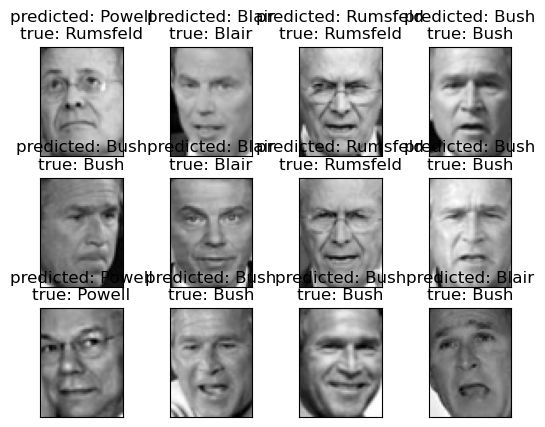

In [126]:
# Visualization
def plot_gallery(images, titles, h, w, rows=3, cols=4):
    plt.figure()
    for i in range(rows * cols):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i])
        plt.xticks(())
        plt.yticks(())
 
def titles(y_pred, y_test, target_names):
    for i in range(y_pred.shape[0]):
        pred_name = target_names[y_pred[i]].split(' ')[-1]
        true_name = target_names[y_test[i]].split(' ')[-1]
        yield 'predicted: {0}\ntrue: {1}'.format(pred_name, true_name)
 
prediction_titles = list(titles(y_pred, y_test, target_names))
plot_gallery(X_test, prediction_titles, h, w)
